<a href="https://colab.research.google.com/github/csubhodeep/lyrics_overlay/blob/develop/exp/lyrics_overlay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
img = Image.open('./drive/MyDrive/ColabNotebooks/lyrics_overlay_project/data/test2.png')

In [ ]:
grey_image = img.convert('LA')

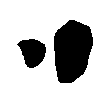

In [ ]:
grey_image

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
grey_image_array = np.array(grey_image)[:,:,0]

In [ ]:
grey_image_array_normalized = MinMaxScaler().fit_transform(grey_image_array)

# Get inferred (segmented) image

Assumptions:
1. The segmentation initially is in the form of rectangular boxes.
2. The input frame is in grey-scale (B&W) and the region inside the bounding box will be filled with black color. (We keep this assumption till we implement the pre-processing function)


In [ ]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
input_words_dict = {'t_0': ['main', 'gaa', 'raha', 'hoon']}

In [ ]:
formations_dict = {
    1: 
}

In [ ]:
def text_fits_box(text: str,
                  font_size: int,
                  height: int,
                  width: int
                  ) -> bool:
    
    # assuming a particular formation e.g. for now one word comes under another

    area_of_box = height*width

    return area_of_box > 20 and width > 10 and height > 10 and height == width

In [ ]:
def get_nearness_to_preferred_centre(centre_1: Tuple[int, int], 
                                     centre_2: Tuple[int, int])->int:

    return ((centre_1[0]-centre_2[0])**2+(centre_1[1]-centre_2[1])**2)**(0.5)

In [ ]:
def get_overlap_with_mask(image: np.ndarray, 
                          lyrics_box_coords: Tuple[Tuple[int,int], Tuple[int,int]],
                          padding: int):
    
    width = abs(lyrics_box_coords[1][0] - lyrics_box_coords[0][0])
    height = abs(lyrics_box_coords[1][1] - lyrics_box_coords[0][1])
    box_array = np.ones(shape=[height+padding, width+padding])

    cropped_image_array = image[lyrics_box_coords[0][1]-padding//2:lyrics_box_coords[1][1]+padding//2, lyrics_box_coords[0][0]-padding//2:lyrics_box_coords[1][0]+padding//2]

    score = (box_array*cropped_image_array).sum()

    return score

In [ ]:
# define loss/cost function
def get_loss(x, # diagonal coords only,
             preffered_centre_coords: Tuple[int, int],
             binary_mask: np.ndarray,
             text: str,
             padding: int = 10,
             font_size: int = 1, # this should be varied from outside
             n_bbox: int = 1) -> float:
    w1 = 0.2
    w2 = 0.8

    lyrics_box_coords: Tuple[Tuple[int,int], Tuple[int, int]] = ((int(x[0]), int(x[1])), (int(x[2]), int(x[3])))
    
    if  lyrics_box_coords[0][0] > lyrics_box_coords[1][0] or lyrics_box_coords[0][1] > lyrics_box_coords[1][1]:
        loss = 100
    else:
        width_of_box = abs(lyrics_box_coords[1][0] - lyrics_box_coords[0][0])
        height_of_box = abs(lyrics_box_coords[1][1] - lyrics_box_coords[0][1])

        box_centre = ((lyrics_box_coords[1][0] + lyrics_box_coords[0][0])//2, (lyrics_box_coords[0][1] + lyrics_box_coords[1][1])//2)

        # TODO: why not exclude certain solutions before triggering the opti algo for faster convergence
        if not text_fits_box(text, font_size, height_of_box, width_of_box):
            loss = 1000
        else:
            nearness_to_preferred_centre = get_nearness_to_preferred_centre(centre_1=preffered_centre_coords,
                                                                            centre_2=box_centre)
            overlap_with_mask = get_overlap_with_mask(image=binary_mask,
                                                    lyrics_box_coords=lyrics_box_coords,
                                                    padding=padding)
            loss = w1*nearness_to_preferred_centre + w2*(overlap_with_mask)
    
    return loss

In [ ]:
def get_preferred_centre():

    # get the centre of the patches

    # then find the centre of the centres - naive centre

    # then find the nearest points in all the patches from the naive centre

    # calculate a new centre using the nearest points

    return (50,50)

In [ ]:
binary_mask = np.zeros([100,100])

In [ ]:
binary_mask[20:80, 20:30] = 1
binary_mask[40:60, 60:80] = 1

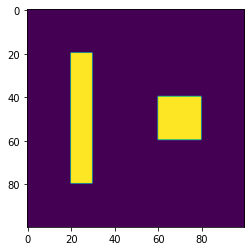

In [ ]:
plt.imshow(binary_mask)

In [ ]:
# hyper parameters
preferred_centre = get_preferred_centre()
lyrics = "I love you"
padding=10
min_ = 0+padding//2
max_ = 100-padding//2
limits = ((min_,max_), (min_,max_), (min_,max_), (min_,max_),)

In [ ]:
res = differential_evolution(get_loss, 
                             bounds=limits, 
                             args=(preferred_centre,binary_mask,lyrics,padding)
                             )

In [ ]:
res

     fun: 0.2
 message: 'Optimization terminated successfully.'
    nfev: 11765
     nit: 195
 success: True
       x: array([43.07175714, 44.87712096, 55.89082285, 56.24253652])

In [ ]:
optimal_coords = ((int(round(res.x[0])), int(round(res.x[1]))), (int(round(res.x[2])), int(round(res.x[3]))))

In [ ]:
new_binary_mask = binary_mask
new_binary_mask[optimal_coords[0][1]:optimal_coords[1][1], optimal_coords[0][0]:optimal_coords[1][0]] = -1

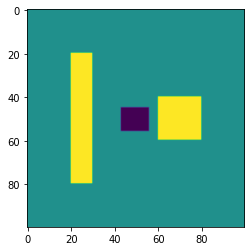

In [ ]:
plt.imshow(new_binary_mask)

In [ ]:
from typing import List

def len_of_text_list(text: List):
  text_pad = 1
  length = text_pad # text pad for left side
  for word in text:
    length += len(word)
    length += 1 # added for a space between word
  length += text_pad # adding text pad for right side
  return length

def text_fits_box(text: List,
                  font_size: int,
                  form: int, # 1,2,3 
                  height: int,
                  width: int
                  ) -> bool:
    
    n_words = len(text)
    max_length = 0
    for i in range(0,len(text)-form,form):
      if i+form < len(text):
        last_index = i+form
      else:
        last_index = len(text)-1
      curr_length = len_of_text_list(text[i:last_index])
      max_length = max(curr_length,max_length)
    
    #max length will never be zero
    expected_width = max_length*font_size
    expected_height = (n_words/form)*font_size

    return expected_width <= width and expected_height <= height

In [ ]:
print(text_fits_box(['i','want','passive','income'],4,2,20,20))   # form=2 so len('_passive_income_') = 16  and 16*4 = 64 > 20 so it cant fit
print(text_fits_box(['i','want','passive','income'],4,2,20,65))   # form=2 so len('_passive_income_') = 16  and 16*4 = 64 < 65 so it can fit

False
True


In [ ]:
text_fits_box(['i'],4,1,20,20)

True